# Ordinary Least Squares (OLS) Linear Regression -- Weighted Data

Andrew Chung, hc893, 4/26/2025

Implementation and Statistical Inference of Ordinary Least Squares (OLS) Regression Models. I will utilize the ridership-weighted data set for OLS modeling and for the remainder of the project.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from matplotlib import pyplot as plt
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

## Import Data, Fit OLS Model

Ordinary Least Squares Linear Model: $\mathbf{y} = \mathbf{Xb}$

In [2]:
data = pd.read_csv("Weighted_Data_Apr23.csv").iloc[:, 1:]  # remove unlabelled index column
X = data.iloc[:, 3:]
y = data['ridership'].to_numpy()/1000 # scale to 1K
# ensure that X and y are equal in size
assert X.shape[0] == y.size, "Incompatible X and y dimensions"

ols = sm.OLS(y, sm.add_constant(X)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     33.38
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           4.29e-37
Time:                        17:17:27   Log-Likelihood:                -1189.0
No. Observations:                 184   AIC:                             2402.
Df Residuals:                     172   BIC:                             2441.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -81.3493     22.403     -3.631      0.000    -125.569     -37.129
additional_platform_time         5.4055     40.392      0.134      0.894     -74.323      85.134
additional_train_time           22.3040     31.048      0.718      0.474     -38.980      83.588
over_five_mins_perc           -508.4364    383.485     -1.326      0.187   -1265.379     248.506
wait_assessment                357.7608    287.051      1.246      0.214    -208.835     924.356
service_delivered             -749.7911    327.022     -2.293      0.023   -1395.283    -104.299
terminal_on_time_performance   669.3684    174.535      3.835      0.000     324.863    1013.874
percent_late                   451.8694    556.650      0.812      0.418    -646.875    1550.614
infra_critical                  -3.1200      5.665     -0.551      0.583     -14.302       8.062
noninfra_critical               13.0966      7.049      1.858      0.065      -0.818      27.011
infra_noncritical                0.0799      0.031      2.579      0.011       0.019       0.141
noninfra_noncritical            -0.0220      0.053     -0.415      0.679      -0.127       0.083
==============================================================================
Omnibus:                       75.617   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.635
Skew:                           1.430   Prob(JB):                     3.76e-93
Kurtosis:                       9.880   Cond. No.                     2.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residual Diagnostics

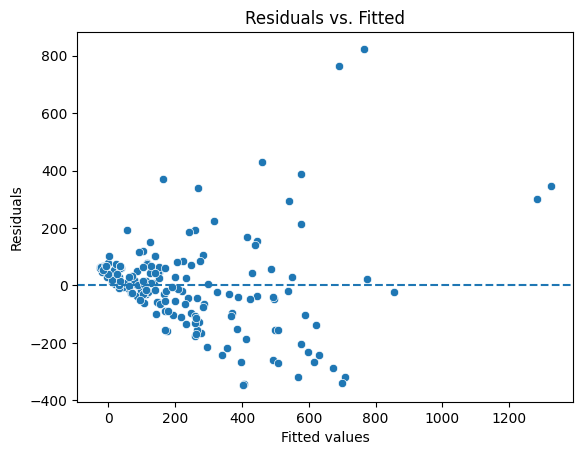

In [3]:
# Residual plot
resid = ols.resid
y_ = ols.fittedvalues
plt.figure()
sns.scatterplot(x = y_, y = resid)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

Non-constant variance - **heteroskedascity** (as fitted values increase) and extreme outliers plague the raw OLS model. I will thus perform a **log-transformation of the response** to look for improvement.

## Fit Log-Transformed Model

Log-Transformed Ordinary Least Squares Linear Model: $\log(\mathbf{y}) = \mathbf{Xb}$

In [4]:
ols_log = sm.OLS(np.log(y), sm.add_constant(X)).fit()
ols_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     32.90
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           9.75e-37
Time:                        18:37:05   Log-Likelihood:                -152.96
No. Observations:                 184   AIC:                             329.9
Df Residuals:                     172   BIC:                             368.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            3.8655      0.080     48.113      0.000       3.707       4.024
additional_platform_time         0.2234      0.145      1.542      0.125      -0.063       0.509
additional_train_time            0.0009      0.111      0.008      0.994      -0.219       0.221
over_five_mins_perc             -4.0145      1.375     -2.919      0.004      -6.729      -1.300
wait_assessment                 -1.6667      1.029     -1.619      0.107      -3.699       0.365
service_delivered                1.1278      1.173      0.962      0.338      -1.187       3.443
terminal_on_time_performance     0.6561      0.626      1.048      0.296      -0.579       1.892
percent_late                     2.5121      1.996      1.258      0.210      -1.428       6.452
infra_critical                  -0.0092      0.020     -0.453      0.651      -0.049       0.031
noninfra_critical                0.0707      0.025      2.799      0.006       0.021       0.121
infra_noncritical                0.0001      0.000      1.118      0.265    -9.5e-05       0.000
noninfra_noncritical            -0.0002      0.000     -1.044      0.298      -0.001       0.000
==============================================================================
Omnibus:                        5.765   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                3.449
Skew:                           0.130   Prob(JB):                        0.178
Kurtosis:                       2.382   Cond. No.                     2.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

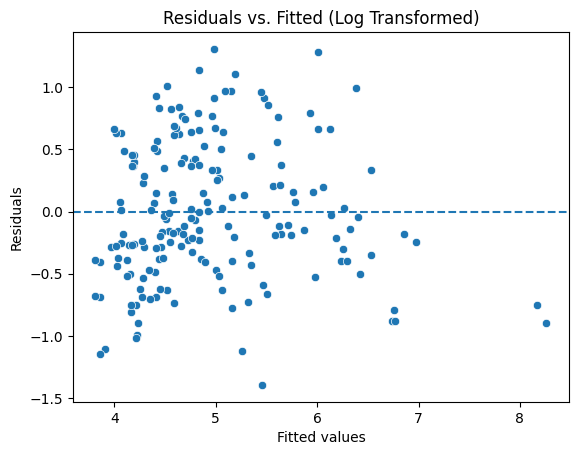

In [5]:
resid = ols_log.resid
y_ = ols_log.fittedvalues
plt.figure()
sns.scatterplot(x = y_, y = resid)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted (Log Transformed)')
plt.show()

Marked improvement in homoscedascity and residual magnitude is observed, at a negligible cost in $R^2$.

## QQ Plots

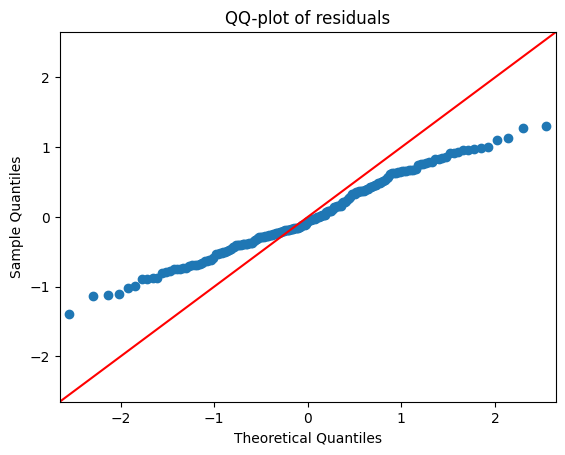

In [6]:
sm.qqplot(resid, line = '45')
plt.title('QQ-plot of residuals')
plt.show()

The QQ plot verifies that the residuals are close to normal -- albeit a slight deviation in the extremes -- validating our linear assumptions. Systematic deviations away from the 45-degree line at moderate to extreme quantiles exist, but are relatively minor and likely acceptable for inference in large samples.

## Coefficients and CI

In [7]:
coefs = pd.concat([ols_log.params, ols_log.conf_int()], axis = 1)
coefs.columns = ['coeff', 'lower', 'upper']
coefs

,coeff,lower,upper
const,3.865480,3.706898,4.024063
additional_platform_time,0.223424,-0.062500,0.509349
additional_train_time,0.000894,-0.218886,0.220673
over_five_mins_perc,-4.014522,-6.729085,-1.299959
wait_assessment,-1.666745,-3.698681,0.365191
service_delivered,1.127794,-1.187084,3.442672
terminal_on_time_performance,0.656094,-0.579379,1.891568
percent_late,2.512147,-1.428192,6.452486
infra_critical,-0.009205,-0.049308,0.030897
noninfra_critical,0.070749,0.020848,0.120650
